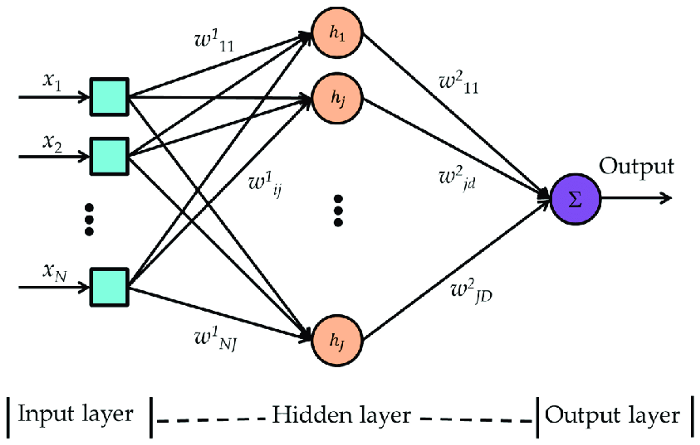

The choice of Activation Functions (AF) has proven
to be an important factor that affects the performance of an
Artificial Neural Network (ANN). Use a 1-hidden layer neural
network model that adapts to the most suitable activation
function according to the data-set. The ANN model can learn for
itself the best AF to use by exploiting a flexible functional form,
k0 + k1 ∗ x with parameters k0, k1 being learned from multiple
runs.

In [1]:
from random import seed
from random import randrange
from random import random
from math import log
from math import exp
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from math import sqrt
from numpy import mean
from numpy.random import rand

In [2]:
 #Load a iris dataset CSV file obtained from kaggle
def loadCsv(filename):
     trainSet = []
     data_frame = pd.read_csv(filename)
     data_frame['species'] = data_frame['species'].map({'Iris-setosa':0,'Iris-versicolor':1,'Iris-virginica':2})
     trainSet = data_frame.values.tolist()
     return trainSet 

In [3]:
# Find the min and max values for each column
def minmax(dataset):
        minmax = list()
        stats = [[min(column), max(column)] for column in zip(*dataset)]
        return stats
 
# Rescale dataset columns to the range 0-1
def normalize(dataset, minmax):
        for row in dataset:
                for i in range(len(row)-1):
                        row[i] = (row[i] - minmax[i][0]) / (minmax[i][1] - minmax[i][0])

In [4]:
# Convert string column to integer
def column_to_int(dataset, column):
        class_values = [row[column] for row in dataset]
        unique = set(class_values)
        lookup = dict()
        for i, value in enumerate(unique):
                lookup[value] = i
        for row in dataset:
                row[column] = lookup[row[column]]
        return lookup
 


In [5]:
# Split a dataset into k folds
def cross_validation_split(dataset, n_folds):
        dataset_split = list()
        dataset_copy = list(dataset)
        fold_size = int(len(dataset) / n_folds)
        for i in range(n_folds):
                fold = list()
                while len(fold) < fold_size:
                        index = randrange(len(dataset_copy))
                        fold.append(dataset_copy.pop(index))
                dataset_split.append(fold)
        return dataset_split
 
# Calculate accuracy percentage
def accuracy_met(actual, predicted):
        correct = 0
        for i in range(len(actual)):
                if actual[i] == predicted[i]:
                        correct += 1
        return correct / float(len(actual)) * 100.0

In [6]:
# Evaluate an algorithm using a cross validation split
def run_algorithm(dataset, algorithm, n_folds, *args):
        
        folds = cross_validation_split(dataset, n_folds)
        #for fold in folds:
                #print("Fold {} \n \n".format(fold))
        test_scores = list()
        train_scores = list()
        train_losses=list()
        test_losses= list()
        f1_scores = list()
        k_scores = list()
        for fold in folds:
                #print("Test Fold {} \n \n".format(fold))
                train_set = list(folds)
                train_set.remove(fold)
                train_set = sum(train_set, [])
                test_set = list()
                for row in fold:
                        row_copy = list(row)
                        test_set.append(row_copy)
                        row_copy[-1] = None
                test_actual = [row[-1] for row in fold]
                train_actual= [row[-1] for row in train_set]
                test_predicted,train_predicted,epochs,ep_loss,k0 = algorithm(train_set, test_set,test_actual, *args)             
                test_accuracy = accuracy_met(test_actual, test_predicted)
                train_accuracy = accuracy_met(train_actual, train_predicted)
                #one-hot encoding actual train and test data.
                test_actual_ohe = ohe_encoding(test_actual)
                train_actual_ohe = ohe_encoding(train_actual)
                test_predicted_ohe = ohe_encoding(test_predicted)
                train_predicted_ohe = ohe_encoding(train_predicted)
                test_loss = categorical_cross_entropy(test_actual_ohe, test_predicted_ohe)
                train_loss= categorical_cross_entropy(train_actual_ohe, train_predicted_ohe)
                f1_score, k_score = cal_f1_k_scores(test_actual, test_predicted)
                train_scores.append(train_accuracy)
                test_scores.append(test_accuracy)
                test_losses.append(test_loss)
                train_losses.append(train_loss)
                f1_scores.append(f1_score)
                k_scores.append(k_score)
        return train_scores,test_scores,train_losses,test_losses,f1_scores,k_scores,epochs,ep_loss,k0





In [7]:
#one hot enocoding:
def ohe_encoding(actual):
    ohe_res = list()
    for a in actual:
      if (a==0): 
          ohe_res.append([1,0,0]) #Class1 {1,0,0}
      elif (a==1):
          ohe_res.append([0,1,0]) #Class2 {0,1,0}
      elif (a==2):
          ohe_res.append([0,0,1]) #Class3 {0,0,1} 
    return ohe_res 


# calculating categorical cross entropy
def categorical_cross_entropy(actual, predicted):
	sum_score = 0.0
	for i in range(len(actual)):
		for j in range(len(actual[i])):
			sum_score += actual[i][j] * log(1e-15 + predicted[i][j])
	mean_sum_score = 1.0 / len(actual) * sum_score
	return -mean_sum_score

In [8]:
def cal_f1_k_scores(actual, predicted):
   cm = confusion_matrix(actual, predicted)
   FP = cm.sum(axis=0) - np.diag(cm)
   FN = cm.sum(axis=1) - np.diag(cm)
   TP = np.diag(cm)
   TN = cm.sum() - (FP + FN + TP)
   TPR = TP/(TP+FN)
   TNR = TN/(TN+FP)
   Precision = TP/(TP+FP)
   Recall = TP/(TP+FN)
   Acc = (TP+TN)/(TP+TN+FP+FN)
   Fscore = 2*(Precision*Recall)/(Precision+Recall)
   k=cohen_kappa_score(actual, predicted)
   return Fscore,k


In [9]:
# Calculate neuron activation for an input
def activate(weights, inputs):
        activation = weights[-1]
        for i in range(len(weights)-1):
                activation += weights[i] * inputs[i]
        return activation
 
# Transfer neuron sigmoid activation function
def transfer(activation,activation_function):
       if activation_function == "sigmoid":
            return 1.0 / (1.0 + exp(-activation))
       elif activation_function == "tanh":
            return np.tanh(activation)
       elif activation_function == "relu":
            return np.maximum(0,activation)
       elif activation_function == "leaky_relu":
            return np.maximum(0.01*activation,activation)

# def softmax(self, X):
#     exps = np.exp(X)
#     return exps / np.sum(exps, axis=1).reshape(-1,1)

# Calculate the derivative of an neuron output
def transfer_derivative(output,activation_function):
        if activation_function == "sigmoid":
            return output * (1.0 - output)
        elif activation_function == "tanh":
             return (1-output**2)
        elif activation_function == "relu":
             return 1.0*(output>0)
        elif activation_function == "leaky_relu":
             if output>0:
               return 1.0
             else:
               return 0.01


 
# # Forward propagate input to a network output
# def forward_propagate(network, row, af):
#         inputs = row
#         for layer in network:
#                 new_inputs = []
#                 for neuron in layer:
#                         activation = activate(neuron['weights'], inputs)
#                         neuron['output'] = transfer(activation,af)
#                         new_inputs.append(neuron['output'])
#                 inputs = new_inputs
#         return inputs
 
 # Forward propagate input to a network output
def forward_propagate(network, row,af):
        inputs = row
        #hidden layer
        layer = network[0]  
        new_inputs = []                     
        for neuron in layer:
              activation = activate(neuron['weights'], inputs)
              neuron['output'] = transfer(activation,af)
              new_inputs.append(neuron['output'])
        inputs = new_inputs
        #output layer
        layer = network[1]
        new_inputs = []        
        for neuron in layer:
              activation = activate(neuron['weights'], inputs)
              neuron['output'] = transfer(activation,'sigmoid')
              new_inputs.append(neuron['output'])
        inputs = new_inputs
        return inputs

In [ ]:
# # Backpropagate error and store in neurons
# def backward_propagate_error(network, expected,af):
#         for i in reversed(range(len(network))):
#                 layer = network[i]
#                 errors = list()
#                 if i != len(network)-1:
#                         for j in range(len(layer)):
#                                 error = 0.0
#                                 for neuron in network[i + 1]:
#                                         error += (neuron['weights'][j] * neuron['delta'])
#                                 errors.append(error)
#                 else:
#                         for j in range(len(layer)):
#                                 neuron = layer[j]
#                                 errors.append(expected[j] - neuron['output'])
#                 for j in range(len(layer)):
#                         neuron = layer[j]
#                         neuron['delta'] = errors[j] * transfer_derivative(neuron['output'],af)

In [10]:
# Backpropagate error and store in neurons
def backward_propagate_error(network, expected,af):
        for i in reversed(range(len(network))):
                layer = network[i]
                errors = list()
                if i != len(network)-1:
                        for j in range(len(layer)):
                                error = 0.0
                                for neuron in network[i + 1]:
                                        error += (neuron['weights'][j] * neuron['delta'])
                                errors.append(error)
                        for j in range(len(layer)):
                              neuron = layer[j]
                              neuron['delta'] = errors[j] * transfer_derivative(neuron['output'],af)
                else:
                        for j in range(len(layer)):
                                neuron = layer[j]
                                errors.append(expected[j] - neuron['output'])
                        for j in range(len(layer)):
                              neuron = layer[j]
                              neuron['delta'] = errors[j] * transfer_derivative(neuron['output'],'sigmoid')

In [11]:
# Update network weights with error
def update_weights(network, row, l_rate):
	for i in range(len(network)):
		inputs = row[:-1]
		if i != 0:
			inputs = [neuron['output'] for neuron in network[i - 1]]
		for neuron in network[i]:
			 for j in range(len(inputs)):
				  neuron['weights'][j] += l_rate * neuron['delta'] * inputs[j]
			 neuron['weights'][-1] += l_rate * neuron['delta']
                                
 
# # Train a network for a fixed number of epochs
def train_network(network, train,test,test_actual, l_rate, n_epoch, n_outputs,af):
        epochs=list()
        k0 = list()
        ep_loss = list() #test loss at the end of each epoch
        for epoch in range(n_epoch):
                for row in train:
                        outputs = forward_propagate(network, row,af)
                        #print(network)
                        expected = [0 for i in range(n_outputs)]
                        expected[row[-1]] = 1                  
                        backward_propagate_error(network, expected,af)
                        update_weights(network, row, l_rate)
                if ((epoch % 50 == 0)or(epoch == 1)):
                       epochs.append(epoch)                  
                       loss = epoch_vs_loss(network,train,test,test_actual)
                       ep_loss.append(loss)
                       for layer in network:
                          bias = list()
                          for neuron in layer:
                             bias.append(neuron['weights'][-1])
                          k0.append(bias)                
        return epochs,ep_loss,k0
 
#predicting loss vs epoch
def epoch_vs_loss(network,train,test,test_actual):
      test_predictions,train_predictions = train_test_prediction(network,train,test)
      test_predicted_ohe = ohe_encoding(test_predictions)
      test_temp_ohe = ohe_encoding(test_actual)              
      test_loss = categorical_cross_entropy(test_temp_ohe, test_predicted_ohe)
      return test_loss
              
def weights_init(name,n,m):
       if name == 'tanh':
            res = random()
       elif name == 'relu':
           res = he_normal(n)
       elif name == 'leaky_relu':
           res = he_normal(n)
       elif name  == 'sigmoid':
            res = xavier_glorot(n,m)
       return res
      
def xavier_glorot(n,m):    
  # number of nodes in the previous layer is n
  # number of nodes in the next layer is m
  # calculate the range for the weights
  lower, upper = -(sqrt(6.0) / sqrt(n + m)), (sqrt(6.0) / sqrt(n + m))
  # generate random numbers
  numbers = random()
  # scale to the desired range
  scaled = lower + numbers * (upper - lower)
  return scaled

def he_normal(n):
  # number of nodes in the previous layer is n
  # calculate the range for the weights
  std = sqrt(2.0 / n)
  # generate random numbers
  numbers = random()
  # scale to the desired range
  scaled = numbers * std
  return scaled

# Initialize a network
def initialize_network(n_inputs, n_hidden, n_outputs,af):
	      network = list()
	      hidden_layer = [{'weights':[weights_init(af,n_inputs,n_outputs) for i in range(n_inputs + 1)]} for i in range(n_hidden)]
	      network.append(hidden_layer)
	      output_layer = [{'weights':[weights_init(af,n_hidden,1) for i in range(n_hidden + 1)]} for i in range(n_outputs)]
	      network.append(output_layer)
	      return network
  
 
# Make a prediction with a network
def predict(network, row):
        outputs = forward_propagate(network, row,af)
        return outputs.index(max(outputs))
 
# Backpropagation Algorithm With Stochastic Gradient Descent
def back_propagation(train, test, test_actual, l_rate, n_epoch, n_hidden,af):
        n_inputs = len(train[0]) - 1
        n_outputs = len(set([row[-1] for row in train]))
        network = initialize_network(n_inputs, n_hidden, n_outputs,af)
        epochs,ep_loss,k0 = train_network(network, train,test, test_actual,l_rate, n_epoch, n_outputs,af)
        test_predictions,train_predictions = train_test_prediction(network,train,test)
        print("The weights, biases and output values at the end of training each fold")
        print(network)
        return test_predictions,train_predictions,epochs,ep_loss,k0

In [12]:
def train_test_prediction(network,train,test):
  train_predictions = list()
  test_predictions = list()
  #predicting test values
  for row in test:
          test_prediction = predict(network, row)
          test_predictions.append(test_prediction)
  #predicting train values
  for row in train:
          train_prediction = predict(network, row)
          train_predictions.append(train_prediction)
  return test_predictions,train_predictions

In [14]:
# load and prepare data
# Test Backprop on Seeds dataset
seed(1)
# load and prepare data
filename = 'IRIS.csv'
dataset = loadCsv(filename)

In [15]:
# convert class column to integers
column_to_int(dataset, len(dataset[0])-1)
# normalize input variables
minmax = minmax(dataset)
normalize(dataset, minmax)


## Sigmoid Activation

In [16]:
# # evaluate algorithm using sigmoid activation function using xavier glorot weight intialzier
n_folds = 5
l_rate = 0.005 
mu=0.001
n_epoch = 600
n_hidden = 5
af = 'sigmoid'
sig_train_scores,sig_test_scores,sig_train_losses,sig_test_losses,sig_f1_scores,sig_k_scores,epochs,sig_ep_loss,k0 = run_algorithm(dataset, back_propagation, n_folds, l_rate, n_epoch, n_hidden,af)


The weights, biases and output values at the end of training each fold
[[{'weights': [0.9968104523716221, -0.2562154393279155, 1.4495985391433437, 1.886162592697761, -2.1201444991262512], 'output': 0.5728315822425174, 'delta': -0.07236935210434448}, {'weights': [0.34158523575218586, 1.1866652746400723, -1.5624741296170828, -1.9743032008803572, 0.7824406450233908], 'output': 0.3767098299832214, 'delta': 0.045116137982051295}, {'weights': [1.3903644096485845, -1.5286216418181364, 1.1038713034200764, 2.0066260669886145, -0.41500555492832103], 'output': 0.8110887742303176, 'delta': 0.011674619916770428}, {'weights': [-0.7232520125519439, -0.6350936760597272, 0.13769233137344764, -0.4162708109410464, -0.7420369831567334], 'output': 0.16210838811651138, 'delta': -0.0033421628478778843}, {'weights': [-0.16212254842004234, 1.3531923085514082, -1.7313379933323616, -1.3441724014197287, -0.07693485932624984], 'output': 0.2131442673880566, 'delta': -0.018196376165498872}], [{'weights': [-2.5180277

In [17]:
k0_hidden = k0[0:][::2]
k0_output = k0[1:][::2]

### Plotting Bias term(k0) of each neuron in hidden layer vs epoch for sigmoid activation function with Glorot Normal weight Intializer

Text(0, 0.5, 'Bais term K0')

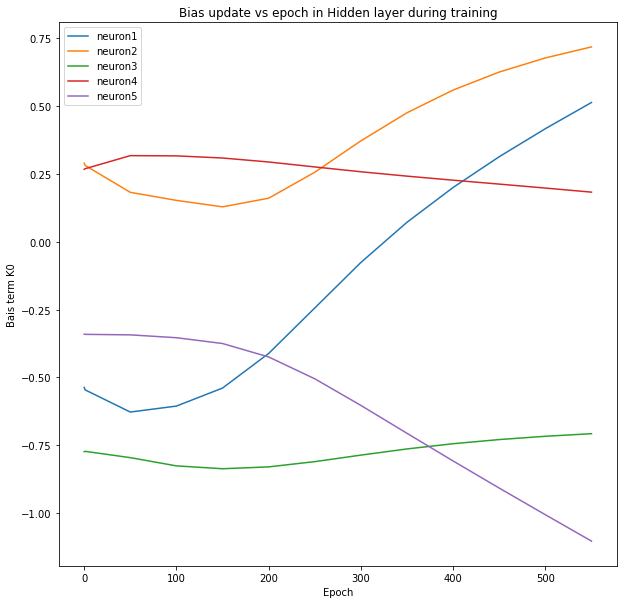

In [18]:
ep2 = list(epochs)
plt.figure(figsize=(10,10))
plt.plot(ep2,k0_hidden)
plt.title('Bias update vs epoch in Hidden layer during training')
plt.legend(['neuron1', 'neuron2', 'neuron3', 'neuron4', 'neuron5'])
plt.xlabel("Epoch")
plt.ylabel("Bais term K0")

## Plotting Bias term(k0) of each neuron in output layer vs epoch

Text(0, 0.5, 'Bais term K0')

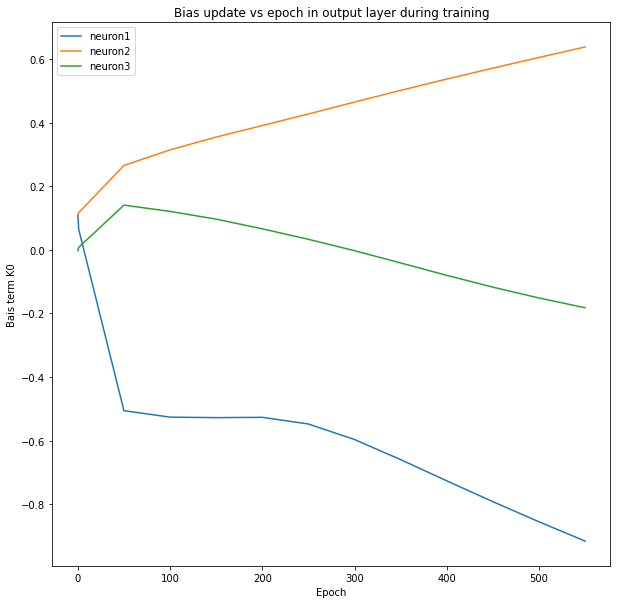

In [19]:
ep2 = list(epochs)
plt.figure(figsize=(10,10))
plt.plot(ep2,k0_output)
plt.title('Bias update vs epoch in output layer during training')
plt.legend(['neuron1', 'neuron2', 'neuron3'])
plt.xlabel("Epoch")
plt.ylabel("Bais term K0")

In [20]:
print('Train Scores of sigmoid activation function : %s' % sig_train_scores)
print('Mean Train Accuracy of sigmoid activation function: %.3f%%' % (sum(sig_train_scores)/float(len(sig_train_scores))))
print('\n')
print('Test Scores of sigmoid activation function: %s' % sig_test_scores)
print('Mean Test Accuracy of sigmoid activation function: %.3f%%' % (sum(sig_test_scores)/float(len(sig_test_scores))))

Train Scores of sigmoid activation function : [95.0, 84.16666666666667, 89.16666666666667, 85.0, 79.16666666666666]
Mean Train Accuracy of sigmoid activation function: 86.500%


Test Scores of sigmoid activation function: [93.33333333333333, 86.66666666666667, 100.0, 80.0, 76.66666666666667]
Mean Test Accuracy of sigmoid activation function: 87.333%


In [21]:
print('Train Losses of sigmoid activation function: %s' % sig_train_losses)
print('Mean Train loss of sigmoid activation function: %.3f%%' % (sum(sig_train_losses)/float(len(sig_train_losses))))
print('\n')
print('Test Losses of sigmoid activation function: %s' % sig_test_losses)
print('Mean Test loss of sigmoid activation function: %.3f%%' % (sum(sig_test_losses)/float(len(sig_test_losses))))

Train Losses of sigmoid activation function: [1.7269388197455342, 5.468639595860855, 3.741700776115323, 5.1808164592366, 7.195578415606389]
Mean Train loss of sigmoid activation function: 4.663%


Test Losses of sigmoid activation function: [2.3025850929940446, 4.605170185988091, -1.1102230246251563e-15, 6.907755278982137, 8.05904782547916]
Mean Test loss of sigmoid activation function: 4.375%


In [22]:
for i in range(n_folds):
  print(f"\nF1 Score for fold number-{i} is")
  print(sig_f1_scores[i])
 


F1 Score for fold number-0 is
[1.         0.85714286 0.91666667]

F1 Score for fold number-1 is
[1.         0.77777778 0.81818182]

F1 Score for fold number-2 is
[1. 1. 1.]

F1 Score for fold number-3 is
[0.95238095 0.625      0.7826087 ]

F1 Score for fold number-4 is
[1.         0.53333333 0.63157895]


In [23]:
for i in range(n_folds):
  print(f"\n Çohen Kappa Score for fold number-{i} is")
  print(sig_k_scores[i])


 Çohen Kappa Score for fold number-0 is
0.8979591836734694

 Çohen Kappa Score for fold number-1 is
0.801980198019802

 Çohen Kappa Score for fold number-2 is
1.0

 Çohen Kappa Score for fold number-3 is
0.7

 Çohen Kappa Score for fold number-4 is
0.6551724137931035


In [24]:
print(epochs)
print(sig_ep_loss)

[0, 1, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550]
[19.571973290449378, 19.571973290449378, 27.631021115928533, 17.269388197455335, 12.664218011467248, 12.664218011467248, 12.664218011467248, 12.664218011467248, 12.664218011467248, 12.664218011467248, 11.512925464970227, 9.210340371976182, 8.05904782547916]


# Relu Activation

In [25]:
# # evaluate algorithm using relu activation function using he_normal weight intialzier
n_folds = 5
l_rate = 0.005 
mu=0.001
n_epoch = 600
n_hidden = 5
af = 'relu'
relu_train_scores,relu_test_scores,relu_train_losses,relu_test_losses,relu_f1_scores,relu_k_scores,epochs,relu_ep_loss,relu_k0 = run_algorithm(dataset, back_propagation, n_folds, l_rate, n_epoch, n_hidden,af)

The weights, biases and output values at the end of training each fold
[[{'weights': [-0.03446479765220831, -0.46913527240217995, 1.700556007170416, 2.692593728439005, -2.0475670571039646], 'output': 0.3258822616250625, 'delta': -0.320928911763083}, {'weights': [0.30249531617821723, 0.6126674166140091, 0.5076695215115958, 0.9606942755230413, 0.31768419657304664], 'output': 1.5793225166025713, 'delta': -0.02166517725480452}, {'weights': [0.23933717134026103, -0.38383823542398665, 1.6937491666975137, 2.426360815741847, -0.400628959341031], 'output': 2.0427994001692777, 'delta': -0.10439707775355815}, {'weights': [0.7678523152299611, -1.3860446395244765, 1.6531195134983614, 0.7216990353280546, 0.5781451169409293], 'output': 2.105002364959549, 'delta': 0.11214095505591971}, {'weights': [0.5122063475702531, 0.779245270575968, 0.088174388947455, 0.09329259553708111, 1.4734025187570632], 'output': 2.196173568417816, 'delta': 0.047329902108834865}], [{'weights': [-0.1842442001117766, -0.440735

In [26]:
print('Train Scores of relu activation function : %s' % relu_train_scores)
print('Mean Train Accuracy of relu activation function: %.3f%%' % (sum(relu_train_scores)/float(len(relu_train_scores))))
print('\n')
print('Test Scores of relu activation function: %s' % relu_test_scores)
print('Mean Test Accuracy of relu activation function: %.3f%%' % (sum(relu_test_scores)/float(len(relu_test_scores))))

Train Scores of relu activation function : [95.83333333333334, 97.5, 99.16666666666667, 96.66666666666667, 97.5]
Mean Train Accuracy of relu activation function: 97.333%


Test Scores of relu activation function: [96.66666666666667, 96.66666666666667, 90.0, 100.0, 96.66666666666667]
Mean Test Accuracy of relu activation function: 96.000%


In [27]:
print('Train Losses of relu activation function: %s' % relu_train_losses)
print('Mean Train loss of relu activation function: %.3f%%' % (sum(relu_train_losses)/float(len(relu_train_losses))))
print('\n')
print('Test Losses of relu activation function: %s' % relu_test_losses)
print('Mean Test loss of relu activation function: %.3f%%' % (sum(relu_test_losses)/float(len(relu_test_losses))))

Train Losses of relu activation function: [1.4391156831212786, 0.863469409872767, 0.2878231366242554, 1.1512925464970227, 0.863469409872767]
Mean Train loss of relu activation function: 0.921%


Test Losses of relu activation function: [1.1512925464970223, 1.1512925464970225, 3.4538776394910684, -1.1102230246251563e-15, 1.1512925464970223]
Mean Test loss of relu activation function: 1.382%


In [28]:
for i in range(n_folds):
  print(f"\nF1 Score of relu activation for fold number-{i} is")
  print(relu_f1_scores[i])


F1 Score of relu activation for fold number-0 is
[1.         0.95238095 0.92307692]

F1 Score of relu activation for fold number-1 is
[1.         0.94736842 0.95238095]

F1 Score of relu activation for fold number-2 is
[1.         0.88888889 0.86956522]

F1 Score of relu activation for fold number-3 is
[1. 1. 1.]

F1 Score of relu activation for fold number-4 is
[1.         0.94117647 0.95238095]


In [29]:
for i in range(n_folds):
  print(f"\n Çohen Kappa Score for fold number-{i} is")
  print(relu_k_scores[i])


 Çohen Kappa Score for fold number-0 is
0.9481865284974094

 Çohen Kappa Score for fold number-1 is
0.95

 Çohen Kappa Score for fold number-2 is
0.8407079646017699

 Çohen Kappa Score for fold number-3 is
1.0

 Çohen Kappa Score for fold number-4 is
0.949748743718593


In [30]:
relu_k0_hidden = relu_k0[0:][::2]
relu_k0_output = relu_k0[1:][::2]

### Plotting Bias term(k0) of each neuron in hidden layer vs epoch for relu activation function with He Normal weight Intializer

Text(0, 0.5, 'Bais term K0')

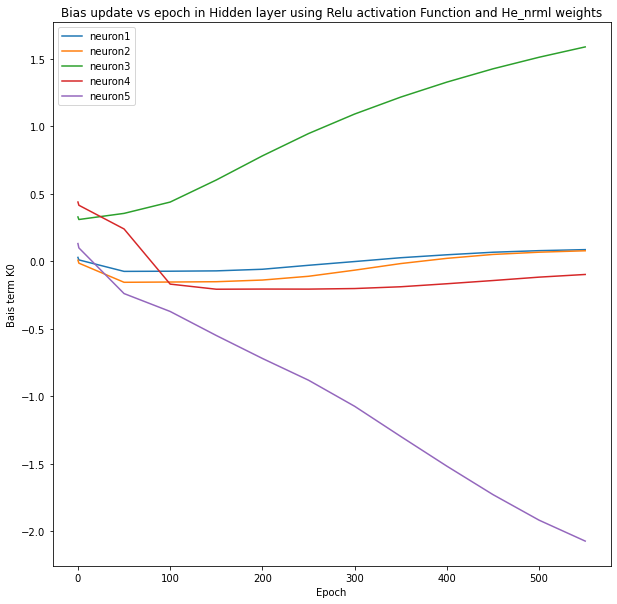

In [33]:
ep2 = list(epochs)
plt.figure(figsize=(10,10))
plt.plot(ep2,relu_k0_hidden)
plt.title('Bias update vs epoch in Hidden layer using Relu activation Function and He_nrml weights')
plt.legend(['neuron1', 'neuron2', 'neuron3', 'neuron4', 'neuron5'])
plt.xlabel("Epoch")
plt.ylabel("Bais term K0")

### Output layer

Text(0, 0.5, 'Bais term K0')

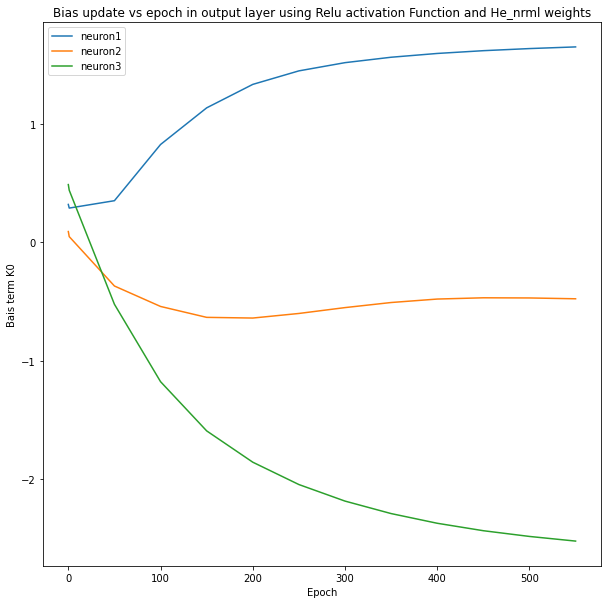

In [34]:
ep2 = list(epochs)
plt.figure(figsize=(10,10))
plt.plot(ep2,relu_k0_output)
plt.title('Bias update vs epoch in output layer using Relu activation Function and He_nrml weights')
plt.legend(['neuron1', 'neuron2', 'neuron3'])
plt.xlabel("Epoch")
plt.ylabel("Bais term K0")

# Tanh Activation Function

In [35]:
# # evaluate algorithm using sigmoid activation function using xavier glorot weight intialzier
n_folds = 5
l_rate = 0.005 
mu=0.001
n_epoch = 600
n_hidden = 5
af = 'tanh'
tanh_train_scores,tanh_test_scores,tanh_train_losses,tanh_test_losses,tanh_f1_scores,tanh_k_scores,epochs,tanh_ep_loss,tanh_k0 = run_algorithm(dataset, back_propagation, n_folds, l_rate, n_epoch, n_hidden,af)

The weights, biases and output values at the end of training each fold
[[{'weights': [0.015234540394029352, 0.39081782144544314, 1.482393293942673, 2.22754136430098, -2.5648292189652424], 'output': 0.31293628757915426, 'delta': 0.25438584763935784}, {'weights': [0.6103173095657102, -0.7286093728531311, 1.4753910206069476, 1.1610990914446506, -0.21650845815294353], 'output': 0.9490452287627408, 'delta': -0.008739243813870283}, {'weights': [-0.6991022913799, 1.9108453692055614, -1.6217821849329757, -1.8702831416109928, 0.490200563172701], 'output': -0.9437021629934185, 'delta': 0.0015629555214040577}, {'weights': [1.0134726350738914, 0.6888308993310591, 0.8987631784185052, 0.904793066706938, 1.3085861691480478], 'output': 0.9980713697122144, 'delta': 0.00019279328394128424}, {'weights': [0.3940714157033695, 0.7021850169430818, 0.567344898072174, 0.6422604787296691, -0.9013276455212568], 'output': 0.44479407955884775, 'delta': 0.06592995213815477}], [{'weights': [-0.3357144546874825, -1.0

In [36]:
print('Train Scores of tanh activation function : %s' % tanh_train_scores)
print('Mean Train Accuracy of tanh activation function: %.3f%%' % (sum(tanh_train_scores)/float(len(tanh_train_scores))))
print('\n')
print('Test Scores of tanh activation function: %s' % relu_test_scores)
print('Mean Test Accuracy of tanh activation function: %.3f%%' % (sum(tanh_test_scores)/float(len(tanh_test_scores))))

Train Scores of tanh activation function : [95.0, 95.0, 95.83333333333334, 97.5, 97.5]
Mean Train Accuracy of tanh activation function: 96.167%


Test Scores of tanh activation function: [96.66666666666667, 96.66666666666667, 90.0, 100.0, 96.66666666666667]
Mean Test Accuracy of tanh activation function: 95.333%


In [37]:
print('Train Losses of tanh activation function: %s' % tanh_train_losses)
print('Mean Train loss of tanh activation function: %.3f%%' % (sum(tanh_train_losses)/float(len(tanh_train_losses))))
print('\n')
print('Test Losses of tanh activation function: %s' % tanh_test_losses)
print('Mean Test loss of tanh activation function: %.3f%%' % (sum(tanh_test_losses)/float(len(tanh_test_losses))))

Train Losses of tanh activation function: [1.7269388197455335, 1.7269388197455342, 1.4391156831212786, 0.863469409872767, 0.8634694098727671]
Mean Train loss of tanh activation function: 1.324%


Test Losses of tanh activation function: [2.3025850929940455, -1.1102230246251563e-15, -1.1102230246251563e-15, 2.302585092994045, 3.453877639491068]
Mean Test loss of tanh activation function: 1.612%


In [38]:
for i in range(n_folds):
  print(f"\nF1 Score of tanh activation for fold number-{i} is")
  print(tanh_f1_scores[i])


F1 Score of tanh activation for fold number-0 is
[1.         0.85714286 0.83333333]

F1 Score of tanh activation for fold number-1 is
[1. 1. 1.]

F1 Score of tanh activation for fold number-2 is
[1. 1. 1.]

F1 Score of tanh activation for fold number-3 is
[1.         0.92857143 0.85714286]

F1 Score of tanh activation for fold number-4 is
[1.         0.88       0.86956522]


In [39]:
for i in range(n_folds):
  print(f"\n Çohen Kappa Score for fold number-{i} is")
  print(tanh_k_scores[i])


 Çohen Kappa Score for fold number-0 is
0.8859315589353612

 Çohen Kappa Score for fold number-1 is
1.0

 Çohen Kappa Score for fold number-2 is
1.0

 Çohen Kappa Score for fold number-3 is
0.8958333333333334

 Çohen Kappa Score for fold number-4 is
0.8448275862068966


In [40]:
tanh_k0_hidden = tanh_k0[0:][::2]
tanh_k0_output = tanh_k0[1:][::2]

## Plotting Bias term(k0) of each neuron in hidden layer vs epoch for tanh activation function with random weight Intializer

Text(0, 0.5, 'Bais term K0')

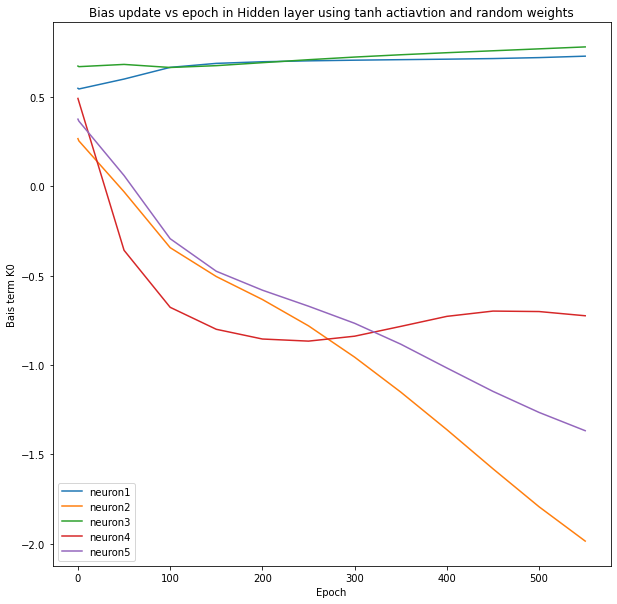

In [41]:
ep2 = list(epochs)
plt.figure(figsize=(10,10))
plt.plot(ep2,tanh_k0_hidden)
plt.title('Bias update vs epoch in Hidden layer using tanh actiavtion and random weights')
plt.legend(['neuron1', 'neuron2', 'neuron3', 'neuron4', 'neuron5'])
plt.xlabel("Epoch")
plt.ylabel("Bais term K0")

## Output layer

Text(0, 0.5, 'Bais term K0')

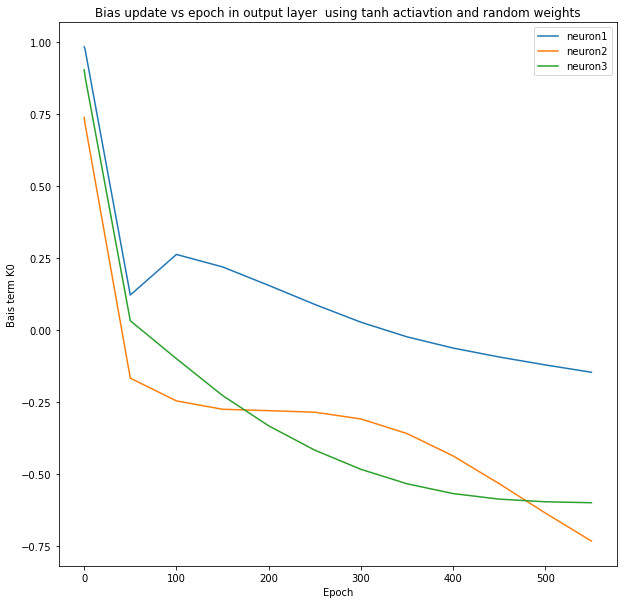

In [42]:
ep2 = list(epochs)
plt.figure(figsize=(10,10))
plt.plot(ep2,tanh_k0_output)
plt.title('Bias update vs epoch in output layer  using tanh actiavtion and random weights')
plt.legend(['neuron1', 'neuron2', 'neuron3'])
plt.xlabel("Epoch")
plt.ylabel("Bais term K0")

## Leaky Relu

In [43]:
# evaluate algorithm using relu activation function using he_normal weight intialzier
n_folds = 5
l_rate = 0.005 
mu=0.001
n_epoch = 600
n_hidden = 5
af = 'leaky_relu'
lrelu_train_scores,lrelu_test_scores,lrelu_train_losses,lrelu_test_losses,lrelu_f1_scores,lrelu_k_scores,epochs,lrelu_ep_loss,lrelu_k0 = run_algorithm(dataset, back_propagation, n_folds, l_rate, n_epoch, n_hidden,af)

The weights, biases and output values at the end of training each fold
[[{'weights': [0.6684404503886714, -0.7816357530600846, 1.607429099573852, 1.3238178759488428, 0.222413009151996], 'output': 0.19540680024666846, 'delta': -0.01689746033198278}, {'weights': [0.22705194387799701, 1.7149410316230231, -1.0505324275407808, -1.0930876158866245, 1.4330318098646275], 'output': 2.4728069098386287, 'delta': 0.014416320791047543}, {'weights': [0.4859067177530103, -0.40904060370370243, 0.8850859670035689, 1.115035147841007, 0.05540107627814366], 'output': 0.13099240120298675, 'delta': -0.007979273341036248}, {'weights': [0.47530535332690194, -0.982641422753733, 2.04136514260704, 2.7612705204921655, -2.312386047442566], 'output': -0.02287190204825357, 'delta': 0.00044807515752485274}, {'weights': [-0.0852054266333105, 0.49706990590613054, -0.08303993614153912, -0.5928603776019886, 0.9862979976667441], 'output': 1.2533912317412998, 'delta': 0.0002258811461860485}], [{'weights': [-1.8328387432800

In [44]:
print('Train Scores of leaky relu activation function : %s' % lrelu_train_scores)
print('Mean Train Accuracy of leaky relu activation function: %.3f%%' % (sum(lrelu_train_scores)/float(len(lrelu_train_scores))))
print('\n')
print('Test Scores of leaky relu activation function: %s' % lrelu_test_scores)
print('Mean Test Accuracy of leaky relu activation function: %.3f%%' % (sum(lrelu_test_scores)/float(len(lrelu_test_scores))))

Train Scores of leaky relu activation function : [99.16666666666667, 97.5, 96.66666666666667, 96.66666666666667, 96.66666666666667]
Mean Train Accuracy of leaky relu activation function: 97.333%


Test Scores of leaky relu activation function: [90.0, 96.66666666666667, 100.0, 90.0, 96.66666666666667]
Mean Test Accuracy of leaky relu activation function: 94.667%


In [45]:
print('Train Losses of leaky relu activation function: %s' % lrelu_train_losses)
print('Mean Train loss of leaky relu activation function: %.3f%%' % (sum(lrelu_train_losses)/float(len(lrelu_train_losses))))
print('\n')
print('Test Losses of leaky relu activation function: %s' % lrelu_test_losses)
print('Mean Test loss of leaky relu activation function: %.3f%%' % (sum(lrelu_test_losses)/float(len(lrelu_test_losses))))

Train Losses of leaky relu activation function: [0.2878231366242549, 0.8634694098727669, 1.1512925464970225, 1.1512925464970225, 1.1512925464970225]
Mean Train loss of leaky relu activation function: 0.921%


Test Losses of leaky relu activation function: [3.4538776394910684, 1.151292546497022, -1.1102230246251563e-15, 3.453877639491068, 1.151292546497022]
Mean Test loss of leaky relu activation function: 1.842%


In [46]:
for i in range(n_folds):
  print(f"\nF1 Score of relu activation for fold number-{i} is")
  print(lrelu_f1_scores[i])


F1 Score of relu activation for fold number-0 is
[1.         0.86956522 0.84210526]

F1 Score of relu activation for fold number-1 is
[1.         0.95652174 0.95238095]

F1 Score of relu activation for fold number-2 is
[1. 1. 1.]

F1 Score of relu activation for fold number-3 is
[1.         0.85714286 0.76923077]

F1 Score of relu activation for fold number-4 is
[1.         0.92307692 0.96774194]


In [47]:
for i in range(n_folds):
  print(f"\n Çohen Kappa Score for fold number-{i} is")
  print(lrelu_k_scores[i])


 Çohen Kappa Score for fold number-0 is
0.8502495840266223

 Çohen Kappa Score for fold number-1 is
0.9494949494949495

 Çohen Kappa Score for fold number-2 is
1.0

 Çohen Kappa Score for fold number-3 is
0.844559585492228

 Çohen Kappa Score for fold number-4 is
0.9458483754512635


In [48]:
lrelu_k0_hidden = lrelu_k0[0:][::2]
lrelu_k0_output = lrelu_k0[1:][::2]

### Plotting Bias term(k0) of each neuron in hidden layer vs epoch for leaky relu activation function with He Normal weight Intializer

Text(0, 0.5, 'Bais term K0')

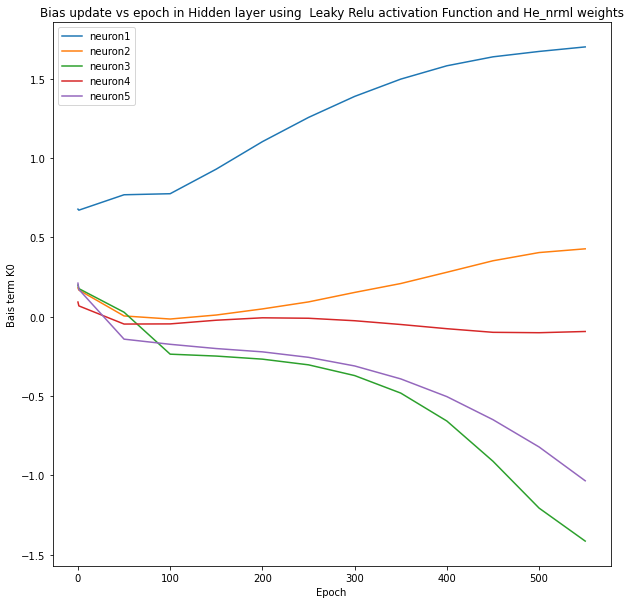

In [49]:
ep2 = list(epochs)
plt.figure(figsize=(10,10))
plt.plot(ep2,lrelu_k0_hidden)
plt.title('Bias update vs epoch in Hidden layer using  Leaky Relu activation Function and He_nrml weights')
plt.legend(['neuron1', 'neuron2', 'neuron3', 'neuron4', 'neuron5'])
plt.xlabel("Epoch")
plt.ylabel("Bais term K0")

### Output Layer

Text(0, 0.5, 'Bais term K0')

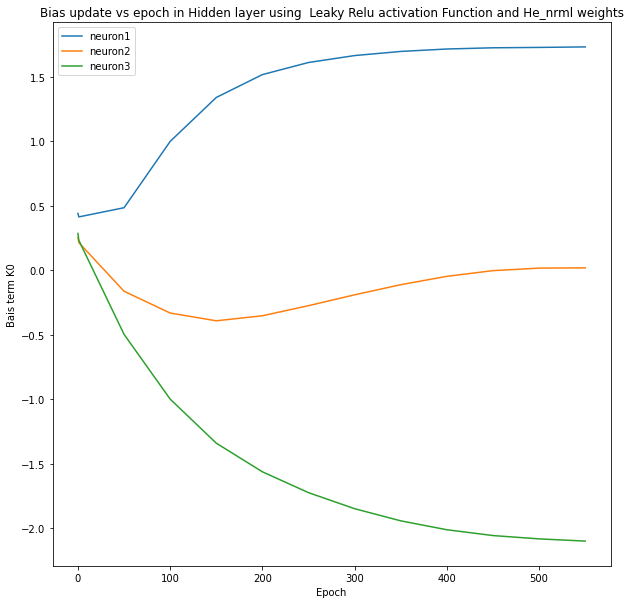

In [50]:
ep2 = list(epochs)
plt.figure(figsize=(10,10))
plt.plot(ep2,lrelu_k0_output)
plt.title('Bias update vs epoch in Hidden layer using  Leaky Relu activation Function and He_nrml weights')
plt.legend(['neuron1', 'neuron2', 'neuron3', 'neuron4', 'neuron5'])
plt.xlabel("Epoch")
plt.ylabel("Bais term K0")

## Epoch Vs Loss Function

Text(0.5, 1.0, 'Activation Functions - Performance')

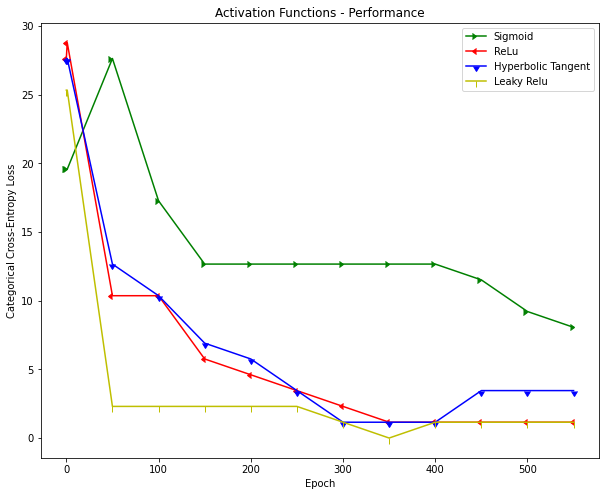

In [52]:
ep2 = list(epochs)
sigm = list(sig_ep_loss)
relu = list(relu_ep_loss)
lrelu = list(lrelu_ep_loss)
tanh = list(tanh_ep_loss)
plt.figure(figsize=(10,8))
l1 , = plt.plot(ep2, sigm, "m-",color='g',label="Sigmoid", marker=5)
l2 , = plt.plot(ep2, relu, "m-",color='r',label="ReLu", marker=8)
l3 , = plt.plot(ep2, tanh, "m-",color='b',label="Hyperbolic Tangent",marker=11)
l4 , = plt.plot(ep2, lrelu, "m-",color='y',label="Leaky Relu",marker=3)
plt.legend(handles=[l1,l2,l3,l4], loc=1)
plt.xlabel("Epoch")
plt.ylabel("Categorical Cross-Entropy Loss")
plt.title("Activation Functions - Performance")